In [89]:
import pandas as p
import numpy as np
import matplotlib.pyplot as plt
import seaborn as s
import pickle

import warnings
warnings.filterwarnings('ignore')

import datetime as dt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats import shapiro

plt.rcParams['figure.figsize'] = [15,8]

In [90]:
df = p.read_csv('train.csv')
df.drop('ID', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             19237 non-null  int64  
 1   Levy              19237 non-null  object 
 2   Manufacturer      19237 non-null  object 
 3   Model             19237 non-null  object 
 4   Prod. year        19237 non-null  int64  
 5   Category          19237 non-null  object 
 6   Leather interior  19237 non-null  object 
 7   Fuel type         19237 non-null  object 
 8   Engine volume     19237 non-null  object 
 9   Mileage           19237 non-null  object 
 10  Cylinders         19237 non-null  float64
 11  Gear box type     19237 non-null  object 
 12  Drive wheels      19237 non-null  object 
 13  Doors             19237 non-null  object 
 14  Wheel             19237 non-null  object 
 15  Color             19237 non-null  object 
 16  Airbags           19237 non-null  int64 

In [91]:
##MILEAGE
df.Mileage = p.to_numeric(df.Mileage.apply(lambda x: float(str(x).split(' ')[0])))

##LEVY
#Replacing hyphens with 0s
def replaceHyphen(n):
    if n == '-':
        return 0.0
    return float(n)
df.Levy = p.to_numeric(df.Levy.apply(lambda x: replaceHyphen(x)))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             19237 non-null  int64  
 1   Levy              19237 non-null  float64
 2   Manufacturer      19237 non-null  object 
 3   Model             19237 non-null  object 
 4   Prod. year        19237 non-null  int64  
 5   Category          19237 non-null  object 
 6   Leather interior  19237 non-null  object 
 7   Fuel type         19237 non-null  object 
 8   Engine volume     19237 non-null  object 
 9   Mileage           19237 non-null  float64
 10  Cylinders         19237 non-null  float64
 11  Gear box type     19237 non-null  object 
 12  Drive wheels      19237 non-null  object 
 13  Doors             19237 non-null  object 
 14  Wheel             19237 non-null  object 
 15  Color             19237 non-null  object 
 16  Airbags           19237 non-null  int64 

In [92]:
#Getting raw number 
def convToVol(n):
    n = str(n).strip()
    tokens = n.split()
    return float(tokens[0])
#Splitting Turbo and non turbo engine types
def TurboClass(n):
    n = str(n).strip()
    tokens = n.split()
    if len(tokens) == 1:
        return 0
    else:
        return 1

df['Turbo'] = df['Engine volume'].apply(lambda x: TurboClass(x))
df['Engine volume'] = df['Engine volume'].apply(lambda x: convToVol(x))

<AxesSubplot:>

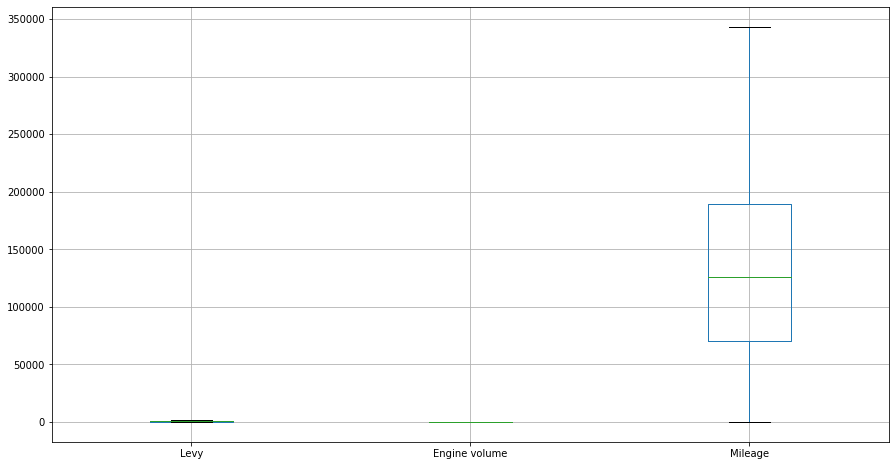

In [93]:
def FindOutliersLim(column_name, df):
    q1 = np.percentile(df[column_name], 25) #1st quartile - 25%
    q3 = np.percentile(df[column_name], 75) #3rd quartile - 75%
    IQR = q3 - q1 #Inter Quartile Range

    liniency_factor = 1.3
    lim = IQR * liniency_factor
    lower_lim, upper_lim = q1 - lim, q3 + lim
    return lower_lim, upper_lim
def RemoveOutlier(df, column_name, upper_lim, lower_lim):
    outlier_list = [x for x in df[column_name] if x < upper_lim] #List of Outliers that exist
    outlier_elimmed = [x for x in df[column_name] if x >= lower_lim and x <= upper_lim]
    final_col = np.where(df[column_name]>upper_lim,upper_lim,np.where(df[column_name]<lower_lim,lower_lim,df[column_name]))
    return final_col
outliers = ['Levy', 'Engine volume', 'Mileage']
for i in outliers:
    lower_lim, upper_lim = FindOutliersLim(column_name=i, df=df)
    df[i] = RemoveOutlier(df, i, upper_lim=upper_lim, lower_lim=lower_lim)
df[outliers].boxplot()

In [94]:
mileage_intervals = [i for i in range(0,10)]
df['Mileage_BIN'] = p.cut(df['Mileage'], len(mileage_intervals), labels=mileage_intervals)
df['Mileage_BIN'] = df['Mileage_BIN'].astype(float)
engineVol_intervals = [i for i in range(0,5)]
df['EngineVolume_BIN'] = p.cut(df['Engine volume'], len(engineVol_intervals), labels=engineVol_intervals)
df['EngineVolume_BIN'] = df['EngineVolume_BIN'].astype(float)

In [95]:
numeric_data = df.select_dtypes(include=np.number)
categ_data = df.select_dtypes(include='object')
encode = OrdinalEncoder()
categ_col = categ_data.columns.tolist()
encode.fit(categ_data[categ_col])

categ_ordinal_encoded = encode.transform(categ_data[categ_col])
categ_ordinal_encoded = p.DataFrame(categ_ordinal_encoded, columns=categ_col)
categ_data.reset_index(inplace=True)
categ_ordinal_encoded.head()

numeric_data.reset_index(inplace=True)
categ_ordinal_encoded.reset_index(inplace=True)
categ_ordinal_encoded.drop('index', axis=1, inplace=True)
final_data = p.concat([numeric_data, categ_ordinal_encoded], axis=1)

# Before Log Transforming Price

<AxesSubplot:>

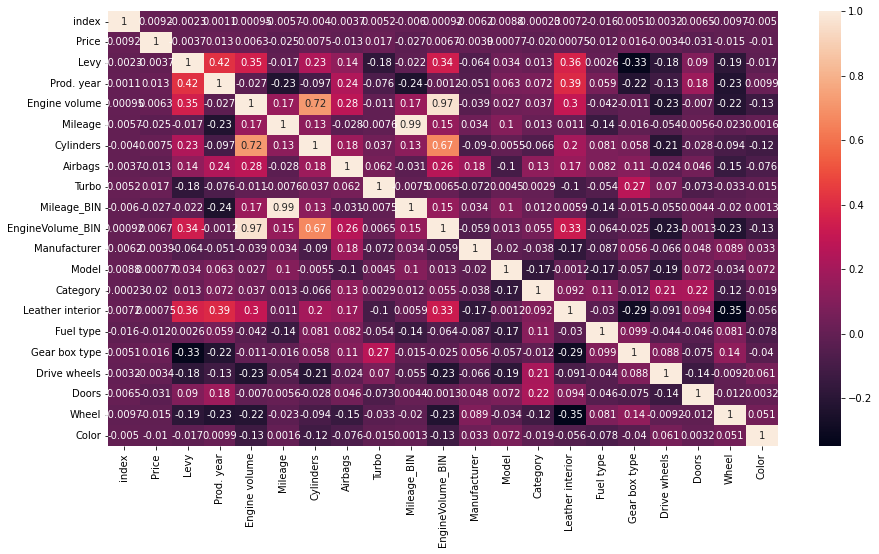

In [96]:
s.heatmap(final_data.corr(), cbar=True, annot=True)

# After Log Transforming Price

<AxesSubplot:>

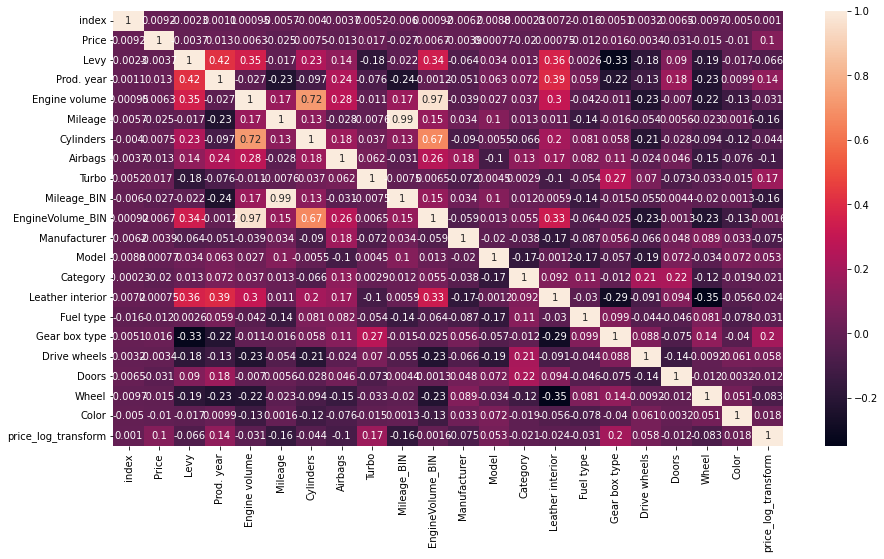

In [97]:
final_data['price_log_transform'] = np.log(final_data['Price'])
s.heatmap(final_data.corr(), cbar=True, annot=True)

In [98]:
import pandas as p
import numpy as np
import matplotlib.pyplot as plt
import seaborn as s
import pickle

import warnings
warnings.filterwarnings('ignore')

import datetime as dt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats import shapiro

plt.rcParams['figure.figsize'] = [15,8]
def ReadTrainData(filename, raw=False) -> p.DataFrame:
    #Reading the data
    df = p.read_csv(filepath_or_buffer=filename)
    df.drop('ID', axis=1, inplace=True)
    
    ##MILEAGE
    df.Mileage = p.to_numeric(df.Mileage.apply(lambda x: float(str(x).split(' ')[0])))

    ##LEVY
    #Replacing hyphens with 0s
    def replaceHyphen(n):
        if n == '-':
            return 0.0
        return float(n)
    df.Levy = p.to_numeric(df.Levy.apply(lambda x: replaceHyphen(x)))
    
    #ENGINE VOLUME
    #Getting raw number
    def convToVol(n):
        n = str(n).strip()
        tokens = n.split()
        return float(tokens[0])
    #Splitting Turbo and non turbo engine types
    def TurboClass(n):
        n = str(n).strip()
        tokens = n.split()
        if len(tokens) == 1:
            return 0
        else:
            return 1
    df['Turbo'] = df['Engine volume'].apply(lambda x: TurboClass(x))
    df['Engine volume'] = df['Engine volume'].apply(lambda x: convToVol(x))


    #OUTLIERS - Pattern breakers/ Exceptions
    def FindOutliersLim(column_name, df):
        q1 = np.percentile(df[column_name], 25) #1st quartile - 25%
        q3 = np.percentile(df[column_name], 75) #3rd quartile - 75%
        IQR = q3 - q1 #Inter Quartile Range
        liniency_factor = 1.3
        lim = IQR * liniency_factor
        lower_lim, upper_lim = q1 - lim, q3 + lim
        return lower_lim, upper_lim

    def RemoveOutlier(df, column_name, upper_lim, lower_lim):
        outlier_list = [x for x in df[column_name] if x < upper_lim] #List of Outliers that exist
        outlier_elimmed = [x for x in df[column_name] if x >= lower_lim and x <= upper_lim]
        final_col = np.where(df[column_name]>upper_lim,upper_lim,np.where(df[column_name]<lower_lim,lower_lim,df[column_name]))
        return final_col

    outliers = ['Levy', 'Engine volume', 'Mileage']
    for i in outliers:
        lower_lim, upper_lim = FindOutliersLim(column_name=i, df=df)
        df[i] = RemoveOutlier(df, i, upper_lim=upper_lim, lower_lim=lower_lim)


    #Creating Intervals aka BIN variables 
    #Alternative to scaling down data
    mileage_intervals = [i for i in range(0,10)]
    df['Mileage_BIN'] = p.cut(df['Mileage'], len(mileage_intervals), labels=mileage_intervals)
    df['Mileage_BIN'] = df['Mileage_BIN'].astype(float)
    engineVol_intervals = [i for i in range(0,5)]
    df['EngineVolume_BIN'] = p.cut(df['Engine volume'], len(engineVol_intervals), labels=engineVol_intervals)
    df['EngineVolume_BIN'] = df['EngineVolume_BIN'].astype(float)


    #Ordinal Encoding Categorical Variables
    numeric_data = df.select_dtypes(include=np.number)
    categ_data = df.select_dtypes(include='object')
    encode = OrdinalEncoder()
    categ_col = categ_data.columns.tolist()
    encode.fit(categ_data[categ_col])

    categ_ordinal_encoded = encode.transform(categ_data[categ_col])
    categ_ordinal_encoded = p.DataFrame(categ_ordinal_encoded, columns=categ_col)
    categ_data.reset_index(inplace=True)
    categ_ordinal_encoded.head()

    numeric_data.reset_index(inplace=True)
    categ_ordinal_encoded.reset_index(inplace=True)
    categ_ordinal_encoded.drop('index', axis=1, inplace=True)
    final_data = p.concat([numeric_data, categ_ordinal_encoded], axis=1)

    #Log Transforming Price to increase relation with other columns 
    #Makes it easier to find a pattern
    final_data['price_log_transform'] = np.log(final_data['Price'])


    return final_data
